# Movie Recommendation System: From Collaborative Filtering to Causal Inference

**Author**: Nishu Kumari Singh  
**Dataset**: MovieLens 100K  
**Goal**: Build a hybrid recommendation system combining matrix factorization
with contextual bandits and evaluate causal effects of genre on ratings

**Key Techniques**: Matrix Factorization, Thompson Sampling, Propensity Score Matching,

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

ratings = pd.read_csv('/content/drive/MyDrive/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/movies.csv')

# Answer these:
print(ratings.shape)
print(f"Users: {ratings.userId.nunique()}")
print(f"Movies: {ratings.movieId.nunique()}")
print(f"Sparsity: {100 * (1 - len(ratings) / (ratings.userId.nunique() * ratings.movieId.nunique())):.2f}%")
print(ratings.rating.value_counts().sort_index())

(100836, 4)
Users: 610
Movies: 9724
Sparsity: 98.30%
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


# Dataset Overview & Intuitions

## Basic Stats
- **100,836 ratings** from **610 users** on **9,724 movies**
- **98.3% sparsity** - most user-movie pairs have NO rating (cold start problem)

## Key Observations from Rating Distribution

### 1. **Positive Bias**
- Ratings skewed toward 3-5 stars (81% of ratings)
- Users rate movies they like, ignore movies they dislike
- **Implication:** Missing ratings ≠ low ratings (missing not at random)

### 2. **Half-Star Granularity**
- 0.5 to 5.0 in 0.5 increments (10 levels)
- More expressive than binary like/dislike
- **Implication:** Can treat as regression (predict exact rating) or classification (predict rating bucket)

### 3. **Cold Start is Real**
- 610 users × 9724 movies = 5.9M possible ratings
- We only have 100K (1.7% observed)
- **Implication:** Need smart exploration (bandits) + collaborative filtering to fill gaps

### 4. **Popular Ratings**
- 4.0 stars is the mode (26,818 ratings - 26.6%)
- Very few extreme negatives (0.5 stars: 1,370)
- **Implication:** Most users are generous raters

---


In [3]:
user_stats = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std']
})
user_stats.describe()

rating                        
             count        mean         std
count   610.000000  610.000000  610.000000
mean    165.304918    3.657222    0.927116
std     269.480584    0.480635    0.266108
min      20.000000    1.275000    0.000000
25%      35.000000    3.360000    0.736026
50%      70.500000    3.694385    0.902378
75%     168.000000    3.997500    1.079056
max    2698.000000    5.000000    2.090642

# User Behavior Analysis

## Summary Statistics: User-Level Patterns

## Key Insights

### 1. **Extreme User Engagement Disparity**
- **Average user:** 165 ratings
- **Range:** 20 to 2,698 ratings (135x difference!)
- **Median:** 70 ratings → 50% of users rated < 70 movies out of 9,724
- **Std:** 269 (higher than mean) → highly skewed distribution, dominated by power users

**Interpretation:** A small group of power users contributes most of the data

---

### 2. **User Rating Bias Exists**
- **Average rating across users:** 3.66 ± 0.48
- **Harsh critic:** 1.27 average (rates everything low)
- **Generous rater:** 5.00 average (rates everything high)

**Interpretation:** Users have different internal rating scales - a "4" from User A ≠ "4" from User B

---

### 3. **Variance in User Discrimination**
- **Average std within user:** 0.93
- **No variance users (std=0):** Some users rate everything identically
- **High variance users (std=2.09):** Use the full 0.5-5.0 scale

**Interpretation:** Low-variance users provide little information about preferences

---

### 4. **Cold Start Problem is Severe**
- **25th percentile:** 35 ratings
- **50th percentile:** 70 ratings
- Only 25% of users have rated > 168 movies

**Interpretation:** Most users have sparse data → traditional collaborative filtering will struggle

---

## How These Insights Drive Our Next Steps

### **Insight 1 → Need User Bias Normalization**
**Problem:** Users have different rating scales (1.27 avg vs 5.0 avg)  
**Solution:** Normalize ratings by subtracting each user's mean  
**Formula:** `normalized_rating = rating - user_mean`  
**Impact:** Makes ratings comparable across users

---

### **Insight 2 → Need to Handle Sparse Users Differently**
**Problem:** 50% of users have < 70 ratings (0.7% coverage of 9,724 movies)  
**Solution:**
- Matrix factorization for users with >100 ratings (reliable embeddings)
- Contextual bandits for sparse users (use demographics/context instead of history)  
**Impact:** Addresses cold start systematically

---

### **Insight 3 → Weight Users by Information Content**
**Problem:** Users with std=0 (rate everything the same) don't help learning  
**Solution:** Weight loss function by user std during training  
**Formula:** `loss_weight = user_std / mean_std`  
**Impact:** Model focuses on informative users

---

### **Insight 4 → Power Users Dominate**
**Problem:** 2698-rating users might bias model toward their preferences  
**Solution:** Cap user influence or use robust loss functions (Huber loss)  
**Impact:** Prevents model from overfitting to power users

---

## Next Analysis Needed

Now that we understand **user patterns**, we need to check **movie patterns**:
- Are some movies rated 1000s of times while others only 5 times?
- Do popular movies get higher ratings (popularity bias)?
- Which movies are controversial (high std) vs universally loved (low std)?

This will tell us if we need **movie-level normalization** too.



In [4]:
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std']
}).reset_index()
movie_stats.columns = ['movieId', 'num_ratings', 'avg_rating', 'std_rating']

print(movie_stats.describe())
print(f"\nMovies with <10 ratings: {(movie_stats.num_ratings < 10).sum() / len(movie_stats) * 100:.1f}%")

             movieId  num_ratings   avg_rating   std_rating
count    9724.000000  9724.000000  9724.000000  6278.000000
mean    42245.024373    10.369807     3.262448     0.839030
std     52191.137320    22.401005     0.869874     0.391432
min         1.000000     1.000000     0.500000     0.000000
25%      3245.500000     1.000000     2.800000     0.629153
50%      7300.000000     3.000000     3.416667     0.837921
75%     76739.250000     9.000000     3.911765     1.051337
max    193609.000000   329.000000     5.000000     3.181981

Movies with <10 ratings: 76.7%


# Movie Popularity Analysis

## Key Insights

### 1. **Severe Long-Tail Distribution**
- **Median:** 3 ratings per movie
- **Mean:** 10.37 ratings per movie (mean > median → right-skewed)
- **25th percentile:** Only 1 rating
- **Max:** 329 ratings (blockbuster)
- **76.7% of movies have < 10 ratings** ← CRITICAL

**Interpretation:** A few blockbusters get tons of ratings, most movies are obscure with almost no data

---

### 2. **Movie Quality Varies Widely**
- **Average rating:** 3.26 ± 0.87 (lower than user avg of 3.66)
- **Range:** 0.5 to 5.0 (full scale used)
- **50th percentile:** 3.42 → half of movies rated below average

**Interpretation:** Movies have genuine quality differences (unlike users who just have rating biases)

---

### 3. **Controversial vs Consensus Movies**
- **Average std:** 0.84 (similar to user-level std of 0.93)
- **Min std:** 0.0 → some movies have universal agreement
- **Max std:** 3.18 → highly divisive movies (love it or hate it)
- **Note:** Only 6278 movies have std (need ≥2 ratings to calculate std)

**Interpretation:** Some movies are safe bets (low std), others are risky (high std)

---

### 4. **The Cold Start Problem is WORSE for Movies**
- **User cold start:** 50% rated < 70 movies (0.7% coverage)
- **Movie cold start:** 76.7% have < 10 ratings
- **Extreme sparsity:** Most movies barely have any feedback

**Interpretation:** Can't reliably estimate quality for most movies

---

## How These Insights Drive Our Next Steps

### **Insight 1 → Can't Treat All Movies Equally**
**Problem:** Movies with 1 rating vs 329 ratings have very different confidence levels  
**Solution:**
- Bayesian approach: Use **prior** (global avg rating) for low-data movies
- Confidence-weighted predictions: `prediction = (n * movie_avg + α * global_avg) / (n + α)`
- **α = regularization strength** (higher α → trust global avg more)  
**Impact:** Prevents overfitting to single ratings

---

### **Insight 2 → Popularity Bias Will Dominate**
**Problem:** 75% of movies have ≤ 9 ratings → model will only learn blockbusters well  
**Solution:**
- **Exploration in bandits:** Force system to try unpopular movies
- **Thompson Sampling shines here:** Naturally explores high-uncertainty movies
- Separate metrics: Accuracy on popular vs niche movies  
**Impact:** System won't just recommend the same 100 blockbusters

---

### **Insight 3 → Need Movie-Level Normalization Too**
**Problem:** Some movies are genuinely better (avg 5.0) vs worse (avg 0.5)  
**Solution:**
- **Unlike user bias (which we remove)**, movie quality is real signal
- Keep movie biases in the model: `rating = user_bias + movie_bias + user_emb · movie_emb`
- User bias = rating scale difference (remove)
- Movie bias = actual quality (keep)  
**Impact:** Model learns true quality differences

---

### **Insight 4 → Controversial Movies = Exploration Opportunity**
**Problem:** High std movies (divisive) might be loved by some, hated by others  
**Solution:**
- Contextual bandits: Match high-std movies to right users based on features
- Example: "Action" movie with high std → show to action lovers, avoid for drama lovers  
**Impact:** Personalization improves for polarizing content

---

## Comparing User vs Movie Patterns

| Metric | Users | Movies | Implication |
|--------|-------|--------|-------------|
| **Median data points** | 70 ratings | 3 ratings | Movies have worse cold start |
| **Mean rating** | 3.66 | 3.26 | Users are generous, movies vary in quality |
| **Sparsity** | 50% < 70 ratings | 76.7% < 10 ratings | Movie cold start is the bigger problem |
| **Std** | 0.93 | 0.84 | Similar variance levels |

---

## Updated Model Design Decisions

### **Matrix Factorization Strategy:**
1. **User embeddings:** Normalize by user mean (remove rating scale bias)
2. **Movie embeddings:** Keep movie bias term (it's real quality signal)
3. **Regularization:** Strong regularization on movies with < 10 ratings (use global prior)
4. **Loss weighting:** Weight by `sqrt(num_ratings)` to balance popular vs niche

### **Bandit Strategy:**
1. **Exploration:** Prioritize movies with < 10 ratings (high uncertainty)
2. **Exploitation:** Use matrix factorization predictions as prior for popular movies
3. **Context:** Use genres to bootstrap cold-start movies

### **Evaluation Strategy:**
1. **Separate metrics:** RMSE on popular movies (>50 ratings) vs niche (<10 ratings)
2. **Coverage:** % of catalog recommended (not just blockbusters)
3. **Diversity:** Entropy of recommended genres

---




In [5]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year
ratings.head()

,userId,movieId,rating,timestamp,year
0,1,1,4.0,2000-07-30 18:45:03,2000
1,1,3,4.0,2000-07-30 18:20:47,2000
2,1,6,4.0,2000-07-30 18:37:04,2000
3,1,47,5.0,2000-07-30 19:03:35,2000
4,1,50,5.0,2000-07-30 18:48:51,2000


In [6]:
# Temporal analysis
print(ratings.year.value_counts().sort_index())

# Do ratings change over time?
yearly_stats = ratings.groupby('year').agg({
    'rating': ['count', 'mean', 'std']
})
print(yearly_stats)

# Are older movies rated differently?
movies['year'] = movies.title.str.extract(r'\((\d{4})\)').astype(float)
rating_with_movie_year = ratings.merge(movies[['movieId', 'year']], on='movieId')
rating_with_movie_year['movie_age'] = rating_with_movie_year['year_x'] - rating_with_movie_year['year_y']

print(rating_with_movie_year.groupby('movie_age')['rating'].mean().head(20))

year
1996     6040
1997     1916
1998      507
1999     2439
2000    10061
2001     3922
2002     3478
2003     4014
2004     3279
2005     5813
2006     4059
2007     7114
2008     4351
2009     4158
2010     2301
2011     1690
2012     4656
2013     1664
2014     1439
2015     6616
2016     6703
2017     8198
2018     6418
Name: count, dtype: int64
     rating                    
      count      mean       std
year                           
1996   6040  3.535927  0.980874
1997   1916  3.727557  0.933223
1998    507  3.435897  1.237320
1999   2439  3.772448  1.119355
2000  10061  3.392506  1.134888
2001   3922  3.512239  1.096924
2002   3478  3.606958  1.080817
2003   4014  3.499377  1.052242
2004   3279  3.506099  0.874243
2005   5813  3.431533  1.043138
2006   4059  3.487928  0.950527
2007   7114  3.309039  1.008109
2008   4351  3.656746  0.910677
2009   4158  3.392496  0.994748
2010   2301  3.463494  0.992019
2011   1690  3.784024  1.040525
2012   4656  3.641323  0.956633
2013   

# Temporal Analysis: Rating Patterns Over Time

## Data Collection Timeline

### Rating Activity by Year
- **Dataset span:** 1996-2018 (23 years)
- **Peak activity:** 2000 (10,061 ratings), 2017 (8,198 ratings)
- **Low activity:** 1998 (507 ratings), 2014 (1,439 ratings)
- **Total:** 100,836 ratings

**Pattern:** Uneven distribution - heavy activity in early 2000s, dip in mid-2010s, surge again 2015-2018

---

## Key Findings

### 1. **Rating Averages Are Remarkably Stable Over Time**

| Period | Mean Rating | Std Rating | Interpretation |
|--------|-------------|------------|----------------|
| 1996 | 3.54 | 0.98 | Baseline |
| 2000 | 3.39 | 1.13 | Slightly lower, higher variance |
| 2007 | 3.31 | 1.01 | **Lowest mean** |
| 2013 | 3.88 | 0.95 | **Highest mean** |
| 2018 | 3.39 | 1.15 | Back to baseline |

**Range:** 3.31 to 3.88 (only 0.57 difference across 23 years!)

**Interpretation:**
- **NO strong rating inflation** (not getting systematically higher/lower)
- **Stable rating behavior** across two decades
- Some year-to-year noise (2013 spike to 3.88, 2007 dip to 3.31)

---

### 2. **Standard Deviation Relatively Constant**

| Metric | Value | Meaning |
|--------|-------|---------|
| Mean std | ~1.00 | Users use similar rating scales across years |
| Min std | 0.87 (2004) | Most agreement |
| Max std | 1.24 (1998) | Most disagreement (but only 507 ratings - noisy) |

**Interpretation:** Rating behavior (how much users vary their ratings) hasn't changed

---

### 3. **Movie Age Has Minimal Effect on Ratings**
```
Movie Age    Avg Rating
-1 years     3.33  (movies rated before release - errors?)
0 years      3.54  (brand new movies)
1-18 years   3.40-3.52  (all within 0.12 range!)
```

**Critical Finding:** Old movies (18 years old) rated ~3.52, new movies ~3.54
- **Difference:** 0.02 stars (negligible!)
- **Interpretation:** NO nostalgia bias or recency bias

---

## What These Results Tell Us

### **Good News: Temporal Priors NOT Needed**

**Why?**
- Mean rating stable (3.31-3.88, mostly around 3.5)
- Movie age doesn't affect ratings
- No systematic drift over 23 years

**Decision:** Use **single global prior** μ = 3.26, not year-specific priors

---

### **Good News: Data is Time-Invariant**

**Implication for Matrix Factorization:**
- Can train on all data equally (2000 ratings as valid as 2018 ratings)
- No need for time-weighted loss functions
- Preferences are stable over time

---

### **Potential Issue: Data Collection Gaps**

**Problem:**
- 2000: 10,061 ratings (peak)
- 2014: 1,439 ratings (trough)
- Uneven sampling across years

**Impact:**
- Model might learn 2000-era user behavior better
- Fewer samples from 2014 → less representation

**Solution:**
- Weight by year? No, because ratings are stable
- Just acknowledge: Model reflects 2000s + 2015-2018 behavior most

---

### **Anomaly: 2013 Spike (3.88 avg)**

**Observation:** 2013 had highest mean (3.88) vs overall mean (3.26)

**Possible explanations:**
1. Selection bias: Users rated only movies they liked that year
2. Great movies released in 2013
3. Small sample (1,664 ratings) → noise


---

### **Anomaly: Movie Age = -1 (Future Ratings?)**

**Observation:** Some movies rated before release year?

**Possible causes:**
1. Year extraction error from movie title
2. Pre-release screenings
3. Data quality issue

---

## Impact on Model Design

### **Matrix Factorization:**
- Use single global prior: μ = 3.26
- No temporal weighting needed
- Train on all data equally
- Acknowledge uneven year sampling in limitations

### **Thompson Sampling (Bandits):**
-  Historical data is relevant (no decay needed)
-  Can use all 100K ratings for initial priors
-  If deploying in 2025, might need fresh data (user preferences may have changed post-2018)

### **Causal Inference:**
-  Time-invariant ratings simplify causal analysis
-  No need to control for temporal confounding
-  But uneven sampling might bias treatment assignment

---

## Revised Prior Strategy

### **Original Question:** Should we use year-specific priors?

**Answer:** **NO - use single global prior**

**Final Prior Settings:**

| Component | Value | Justification |
|-----------|-------|---------------|
| **Global mean (μ)** | 3.26 | Overall average, stable across time |
| **Global std (σ)** | 0.87 | Typical rating variance |
| **Prior strength (α)** | 25 | Equivalent to 25 ratings (tune via CV) |
| **Time decay** | None | Ratings stable 1996-2018 |


In [7]:
# 1. Check genre structure
print(movies.head(10))
print("\nGenre format:")
print(movies.genres.iloc[0])
genre_count = movies.genres.str.split('|').explode().value_counts()
print("\nGenre distribution:")
print(genre_count)

print(movies.genres.str.split('|').explode().unique())


# 2. How many unique genre combinations?
print(f"\nUnique genre combos: {movies.genres.nunique()}")

# 3. What are the most common genres?
print("\nMost common genre combinations:")
print(movies.genres.value_counts().head(10))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres    year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
1                   Adventure|Children|Fantasy  1995.0  
2                               Comedy|Romance  1995.0  
3                         Comedy|Drama|Romance  1995.0  
4                                       Comedy  1995.0  
5                        Action|Crime|Thriller  1995.0  
6                               Comedy|Romance  19

# Genre Feature Extraction - Understanding the Output

## What We Just Discovered

### **Individual Genre Statistics**
- **Total unique genres:** 20
- **Most common:** Drama (4,361 movies), Comedy (3,756), Thriller (1,894)
- **Least common:** Film-Noir (87), Western (167), IMAX (158)
- **Missing data:** 34 movies have "(no genres listed)"

---

## Key Insights

### 1. **Genre Distribution is Heavily Skewed**

| Tier | Genres | Count Range | Examples |
|------|--------|-------------|----------|
| **Popular** | 5 genres | 1,596 - 4,361 | Drama, Comedy, Thriller, Action, Romance |
| **Common** | 8 genres | 573 - 1,263 | Adventure, Crime, Sci-Fi, Horror, Fantasy, Children, Animation, Mystery |
| **Rare** | 7 genres | 87 - 440 | Documentary, War, Musical, Western, IMAX, Film-Noir |

**Interpretation:**
- Drama appears in 44% of movies (4,361 / 9,724)
- Comedy appears in 39% of movies
- Film-Noir only in 0.9% of movies

**Implication for Models:**
- Popular genres → reliable patterns, easier to learn
- Rare genres → high uncertainty, need more exploration (bandits!)

---

### 2. **Multi-Genre Movies are the Norm**

Looking at combinations:
- **Single genre:** "Drama" (1,053), "Comedy" (946), "Horror" (167)
- **Multi-genre:** "Comedy|Drama" (435), "Comedy|Romance" (363)
- **951 unique combinations** → movies are diverse

**Average genres per movie:** We'll calculate this next, but expect 2-3 genres

**Interpretation:**
- Movies aren't single-category
- Users who like "Comedy" might also like "Drama" depending on combination
- **Context matters:** "Comedy|Romance" ≠ "Comedy|Horror"

---

### 3. **Data Quality Issue: 34 Movies Missing Genres**

**Problem:** "(no genres listed)" appears 34 times

**Questions:**
- Are these movies unclassified?
- Are they actually "Unknown" genre?
- Should we remove them or create an "Unknown" category?

**Decision needed before modeling**

---




In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

# Create binary matrix
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies.genres.str.split('|'))

# Convert to DataFrame
genre_features = pd.DataFrame(
    genre_matrix,
    columns=mlb.classes_,
    index=movies.movieId
)

print(f"Shape: {genre_features.shape}")
print("\nFirst 5 movies:")
print(f"\nAvg genres per movie: {genre_features.sum(axis=1).mean():.2f}")
genre_features.head()


Shape: (9742, 20)

First 5 movies:

Avg genres per movie: 2.27


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## One-Hot Encoding Results

- **Shape:** 9,742 movies × 20 genres
- **Average genres per movie:** 2.27
- **Encoding verified:** Toy Story (movieId=1) correctly has Adventure, Animation, Children, Comedy, Fantasy

## Feature Matrix Ready

We now have:
1.  **Ratings data:** 100,836 ratings (user-movie-rating-timestamp)
2.  **User stats:** Sparsity, biases, cold start identified
3.  **Movie stats:** Popularity distribution, quality priors set
4.  **Genre features:** 20-dimensional binary vectors for each movie
5.  **Temporal analysis:** Stable ratings, no time decay needed


In [9]:
from sklearn.model_selection import train_test_split

# Split ratings into train (80%) and test (20%)
train_ratings, test_ratings = train_test_split(
    ratings,
    test_size=0.2,
    random_state=42
)

print(f"Train: {len(train_ratings)} ratings")
print(f"Test: {len(test_ratings)} ratings")

# Check: Are there any users/movies ONLY in test set? (cold start in test)
train_users = set(train_ratings.userId)
test_users = set(test_ratings.userId)
train_movies = set(train_ratings.movieId)
test_movies = set(test_ratings.movieId)

print(f"\nUsers only in test: {len(test_users - train_users)}")
print(f"Movies only in test: {len(test_movies - train_movies)}")

Train: 80668 ratings
Test: 20168 ratings

Users only in test: 0
Movies only in test: 741


# Train-Test Split Analysis

## Split Results
- **Train set:** 80,668 ratings (80%)
- **Test set:** 20,168 ratings (20%)

---

## Critical Finding: Cold Start in Test Set

### **Users:**
-  All test users appear in train set (0 cold start users)
- **Good:** Can evaluate all users

### **Movies:**
-  **741 movies only in test set** (7.6% of 9,724 movies)
- **Problem:** Matrix factorization can't predict ratings for movies it never saw during training
- **This is realistic:** New movies arrive constantly

---

## What This Means

### **For Evaluation:**
We'll have **two test scenarios:**

1. **Warm-start test:** Movies that appeared in training (can use embeddings)
2. **Cold-start test:** 741 new movies (can't use embeddings)

**Matrix Factorization will FAIL on cold-start movies** → This is where contextual bandits shine!

### **For Now:**
- Build matrix factorization on warm-start movies
- Later, bandits will handle cold-start using genre features

In [10]:
train_matrix = train_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  # Fill missing with 0 (we'll mask these later)

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Sparsity: {(train_matrix == 0).sum().sum() / train_matrix.size * 100:.2f}%")

# Store which entries are actual ratings (not missing)
train_mask = (train_matrix > 0).astype(int)
print(f"Actual ratings: {train_mask.sum().sum()}")

Train matrix shape: (610, 8983)
Sparsity: 98.53%
Actual ratings: 80668


In [11]:
import numpy as np

k = 20
learning_rate = 0.01
regularization = 0.02
n_epochs = 20

np.random.seed(42)
user_embeddings = np.random.normal(0, 0.1, (610, k))
movie_embeddings = np.random.normal(0, 0.1, (8983, k))
user_bias = np.zeros(610)
movie_bias = np.zeros(8983)
global_mean = train_ratings.rating.mean()

print(f"Initialized: {user_embeddings.shape}, {movie_embeddings.shape}")
print(f"Global mean: {global_mean:.3f}")

Initialized: (610, 20), (8983, 20)
Global mean: 3.503


## Mapping

In [12]:
# Create mappings
user_id_to_idx = {user_id: idx for idx, user_id in enumerate(train_matrix.index)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(train_matrix.columns)}

# Convert training data to array indices
train_user_indices = train_ratings.userId.map(user_id_to_idx).values
train_movie_indices = train_ratings.movieId.map(movie_id_to_idx).values
train_rating_values = train_ratings.rating.values

print(f"Training on {len(train_rating_values)} ratings")
print(f"Example: UserID {train_ratings.userId.iloc[0]} → array index {train_user_indices[0]}")

Training on 80668 ratings
Example: UserID 509 → array index 508


In [13]:
num_users = len(user_id_to_idx)
num_movies = len(movie_id_to_idx)
k = 20

# hyperparams
lr = 0.01
reg = 0.02
n_epochs = 10
rating_min, rating_max = 0.5, 5.0

# initialize parameters
user_bias = np.zeros(num_users, dtype=np.float64)
movie_bias = np.zeros(num_movies, dtype=np.float64)
user_emb = 0.01 * np.random.randn(num_users, k).astype(np.float64)
movie_emb = 0.01 * np.random.randn(num_movies, k).astype(np.float64)

def predict(u, m):
    return global_mean + user_bias[u] + movie_bias[m] + np.dot(user_emb[u], movie_emb[m])

def compute_rmse():
    sq = 0.0
    for u, m, r in zip(train_user_indices, train_movie_indices, train_rating_values):
        r_hat = predict(u, m)
        # optional: clip for metric
        r_hat = np.clip(r_hat, rating_min, rating_max)
        sq += (r - r_hat) ** 2
    return np.sqrt(sq / len(train_rating_values))

# Training loop
for epoch in range(n_epochs):
    # shuffle
    perm = np.random.permutation(len(train_rating_values))
    for idx in perm:
        u = train_user_indices[idx]
        m = train_movie_indices[idx]
        r = train_rating_values[idx]

        # predict
        r_hat = global_mean + user_bias[u] + movie_bias[m] + np.dot(user_emb[u], movie_emb[m])
        err = r - r_hat

        # keep old user vector for movie update
        user_vec_old = user_emb[u].copy()

        # updates (regularized)
        user_bias[u] += lr * (err - reg * user_bias[u])
        movie_bias[m] += lr * (err - reg * movie_bias[m])

        user_emb[u] += lr * (err * movie_emb[m] - reg * user_emb[u])
        movie_emb[m] += lr * (err * user_vec_old - reg * movie_emb[m])

    # report
    rmse = compute_rmse()
    print(f"Epoch {epoch+1}/{n_epochs} — RMSE: {rmse:.4f}")

print("Training complete!")

Epoch 1/10 — RMSE: 0.8972
Epoch 2/10 — RMSE: 0.8739
Epoch 3/10 — RMSE: 0.8607
Epoch 4/10 — RMSE: 0.8515
Epoch 5/10 — RMSE: 0.8449
Epoch 6/10 — RMSE: 0.8402
Epoch 7/10 — RMSE: 0.8350
Epoch 8/10 — RMSE: 0.8311
Epoch 9/10 — RMSE: 0.8278
Epoch 10/10 — RMSE: 0.8249
Training complete!


### Matrix Factorization Training Results

**What we did:**
Trained a collaborative filtering model using matrix factorization with user/movie biases and latent embeddings (k=20). Used SGD with L2 regularization (λ=0.02) over 10 epochs.

**What we got:**
- Starting RMSE: **0.8972**
- Final RMSE: **0.8249**
- Improvement: **~8%** reduction in error
- The model converged smoothly with consistent improvement each epoch

**Where this points us:**
The steady RMSE drop suggests we could push further—try **more epochs** (20-30) or **tune hyperparameters** (k, learning rate, regularization). Next step: evaluate on a **validation/test set** to check for overfitting before iterating on architecture.

In [14]:
# Baseline: always predict global mean
baseline_rmse = np.sqrt(((train_rating_values - global_mean)**2).mean())
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Our model RMSE: 0.8249")
print(f"Improvement: {(baseline_rmse - 0.8249)/baseline_rmse*100:.1f}%")

Baseline RMSE: 1.0409
Our model RMSE: 0.8249
Improvement: 20.8%


In [15]:
# Test set evaluation
test_user_indices_map = test_ratings.userId.map(user_id_to_idx)
test_movie_indices_map = test_ratings.movieId.map(movie_id_to_idx)

# Keep only warm-start movies (that appeared in training)
valid_mask = test_movie_indices_map.notna()
valid_test = test_ratings[valid_mask].copy()
valid_test['u_idx'] = valid_test.userId.map(user_id_to_idx).astype(int)
valid_test['m_idx'] = valid_test.movieId.map(movie_id_to_idx).astype(int)

# Predict
test_preds = []
for u, m in zip(valid_test.u_idx, valid_test.m_idx):
    pred = predict(u, m)
    test_preds.append(np.clip(pred, rating_min, rating_max))

test_rmse = np.sqrt(((valid_test.rating.values - np.array(test_preds))**2).mean())

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train RMSE: 0.8249")
print(f"Difference: {test_rmse - 0.8249:.4f}")
print(f"\nCold-start movies removed: {(~valid_mask).sum()} / {len(test_ratings)}")

Test RMSE: 0.8755
Train RMSE: 0.8249
Difference: 0.0506

Cold-start movies removed: 813 / 20168


### Model Evaluation & Performance

**Baseline comparison:**
- Baseline (global mean): **1.0409 RMSE**
- Our model (train): **0.8249 RMSE**
- **Improvement: 20.8%** over naive baseline

**Generalization check:**
- Train RMSE: **0.8249**
- Test RMSE: **0.8755**
- Gap: **+0.0506** (5.8% relative increase)

**Cold-start handling:**
- Removed **813/20,168** test samples (4%) with unseen movies
- Model only evaluated on warm-start items

**The limitation:**
While our matrix factorization performs well on known ratings, it's **purely exploitative**—it recommends based on past patterns but doesn't explore new preferences or handle uncertainty in predictions.

**Next step: Thompson Sampling**
Moving to a **Bayesian bandit approach** to balance exploration (trying new recommendations) vs. exploitation (using known preferences), especially valuable for handling new users and diverse content discovery. →

# Phase 2: Contextual Bandits with Thompson Sampling

Goal:
Build an online learning system that:

Handles cold-start movies (the 813 we couldn't predict)
Balances exploration (try uncertain movies) vs exploitation (recommend known good ones)
Uses genre features as context
Learns from user interactions in real-time

In [16]:
# Merge genre features with movie metadata
movie_features_df = movies[['movieId', 'title']].merge(
    genre_features.reset_index(),
    on='movieId'
)

print(f"Movie features shape: {movie_features_df.shape}")
print(f"Features per movie: {genre_features.shape[1]} genres")
print("\nExample features for Toy Story:")
movie_features_df[movie_features_df.movieId == 1]

Movie features shape: (9742, 22)
Features per movie: 20 genres

Example features for Toy Story:


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Create feature matrix with normalization
movie_ids_in_train = list(movie_id_to_idx.keys())

# Normalize movie biases first
movie_bias_norm = (movie_bias - movie_bias.mean()) / movie_bias.std()

features_list = []
for movie_id in movie_ids_in_train:
    # Genre features
    if movie_id in genre_features.index:
        genre_vec = genre_features.loc[movie_id].values
    else:
        genre_vec = np.zeros(20)

    # Normalized MF quality
    m_idx = movie_id_to_idx[movie_id]
    mf_quality = movie_bias_norm[m_idx]

    # Combine [20 genres + 1 normalized MF quality]
    feature_vec = np.concatenate([genre_vec, [mf_quality]])
    features_list.append(feature_vec)

movie_features_matrix = np.array(features_list)

print(f"Shape: {movie_features_matrix.shape}")
print(f"MF quality range: [{movie_bias_norm.min():.2f}, {movie_bias_norm.max():.2f}]")
print(f"Example movie features: {movie_features_matrix[0]}")

Shape: (8983, 21)
MF quality range: [-5.24, 4.10]
Example movie features: [0.         0.         1.         1.         1.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.72177147]


# Contextual Bandit Feature Matrix - Results

## Results:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Shape** | 8,983 × 21 | 8,983 movies, 21 features each |
| **Genre features** | 20 dimensions | Binary (0 or 1) indicating genre presence |
| **MF quality feature** | 1 dimension | Normalized movie bias from Phase 1 |
| **MF quality range** | [-5.24, 4.10] | Standardized scale (mean=0, std=1) |

---

## Example Movie Features Breakdown:
```
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.72]
 ↑  ↑  ↑  ↑  ↑  ↑  ...                                        ↑
 Genre features (20 binary values)                    MF quality (+1.72)
```

**This movie has:**
- Genres at positions 2, 3, 4, 5, 9 (likely Adventure, Animation, Children, Comedy, Fantasy - Toy Story!)
- MF quality = +1.72 std above average → **high-quality movie**

---

## Why This Feature Design Works:

### **1. Genre Features (Context)**
- Tell us WHAT TYPE of movie it is
- Enable cold-start: New movie with "Action|Sci-Fi" → similar to other Action/Sci-Fi movies
- Contextual bandits can learn: "Users who liked Action in the past → explore other Action movies"

### **2. MF Quality Feature (Prior Knowledge)**
- Warm-start movies: MF quality is reliable (many ratings) → high confidence
- Cold-start movies: MF quality = 0 (no data) → high uncertainty → explore more
- **Bridges Phase 1 & Phase 2:** Bandits don't start blind, they use MF knowledge

### **3. Normalization Ensures Balance**
- Without normalization: MF quality (-2 to +2) would dominate binary genres (0 or 1)
- With normalization: All features on similar scale → model weighs them fairly

---

## How Bandits Will Use These Features:

### **Thompson Sampling Process:**

**For each user interaction:**
1. **Context:** User's past genre preferences + current session
2. **Action:** Which movie to recommend?
3. **Features:** Each movie's 21-dimensional vector
4. **Decision:** Sample from belief distribution weighted by features
   - High MF quality + matching genres → likely to recommend (exploitation)
   - Low MF quality but matching genres → might explore (exploration)
   - Mismatched genres → unlikely to recommend

**After user clicks/skips:**
- Update belief about which features predict good ratings
- Learn: "This user likes Comedy (genre 5) + high MF quality movies"

---

## What This Enables:

### **Cold-Start Handling:**
```
New Movie: "Avengers Endgame" (2019)
- Genres: [Action=1, Adventure=1, Sci-Fi=1, ...]
- MF quality: 0 (no historical ratings)

Bandit decision:
- "User liked Action movies before (Iron Man, Thor)"
- "This is Action → try it!" (exploration based on genre match)
- After rating: Update belief about Action movies
```

### **Warm-Start Enhancement:**
```
Old Movie: "Toy Story" (1995)
- Genres: [Adventure=1, Animation=1, Children=1, Comedy=1, Fantasy=1]
- MF quality: +1.72 (highly rated historically)

Bandit decision:
- "MF says it's great (+1.72)"
- "User likes Comedy and Animation"
- "High confidence → recommend!" (exploitation)
```

---

## Ready for Next Step:

We now have:
-  Feature matrix (8,983 × 21)
-  MF predictions as priors
-  Genre context for cold-start



In [18]:
class ThompsonSamplingBandit:
    def __init__(self, n_features, alpha=1.0, lambda_reg=1.0):
        self.n_features = n_features
        self.alpha = alpha
        self.lambda_reg = lambda_reg

        self.B = self.lambda_reg * np.eye(n_features)
        self.mu = np.zeros(n_features)
        self.f = np.zeros(n_features)

    def sample_weights(self):
        # Sample from N(mu, alpha^2 * B^-1)
        B_inv = np.linalg.inv(self.B)
        covariance = self.alpha**2 * B_inv
        sampled_weights = np.random.multivariate_normal(self.mu, covariance)
        return sampled_weights

    def predict(self, features):
        # Reward = features · weights
        sampled_w = self.sample_weights()
        predicted_reward = np.dot(features, sampled_w)
        return predicted_reward

    def update(self, features, reward):
        # Bayesian update
        self.B = self.B + np.outer(features, features)
        self.f = self.f + reward * features
        self.mu = np.linalg.solve(self.B, self.f)

# Initialize
bandit = ThompsonSamplingBandit(n_features=21, alpha=1.0, lambda_reg=1.0)
print("Thompson Sampling Bandit initialized!")

Thompson Sampling Bandit initialized!


In [19]:
# Simulate bandit learning on test set
np.random.seed(42)

# Use test ratings as simulated user interactions
test_user_indices_map = test_ratings.userId.map(user_id_to_idx)
test_movie_indices_map = test_ratings.movieId.map(movie_id_to_idx)

# Keep only movies we have features for
valid_test_bandit = test_ratings[test_movie_indices_map.notna()].copy()
valid_test_bandit['u_idx'] = valid_test_bandit.userId.map(user_id_to_idx).astype(int)
valid_test_bandit['m_idx'] = valid_test_bandit.movieId.map(movie_id_to_idx).astype(int)

print(f"Simulating {len(valid_test_bandit)} interactions")

# Simulate online learning
n_interactions = min(1000, len(valid_test_bandit))  # Start with 1000 interactions
cumulative_reward = 0
rewards_history = []

for i in range(n_interactions):
    # Get user-movie interaction
    u_idx = valid_test_bandit.iloc[i]['u_idx']
    m_idx = valid_test_bandit.iloc[i]['m_idx']
    actual_rating = valid_test_bandit.iloc[i]['rating']

    # Get movie features
    movie_features = movie_features_matrix[m_idx]

    # Bandit predicts
    predicted_reward = bandit.predict(movie_features)

    # User rates (we use actual rating as reward)
    reward = actual_rating

    # Update bandit
    bandit.update(movie_features, reward)

    # Track performance
    cumulative_reward += reward
    rewards_history.append(cumulative_reward / (i + 1))

    if (i + 1) % 200 == 0:
        print(f"Interaction {i+1}: Avg reward = {cumulative_reward / (i+1):.3f}")

print(f"\nFinal average reward: {cumulative_reward / n_interactions:.3f}")

Simulating 19355 interactions
Interaction 200: Avg reward = 3.420
Interaction 400: Avg reward = 3.513
Interaction 600: Avg reward = 3.516
Interaction 800: Avg reward = 3.514
Interaction 1000: Avg reward = 3.494

Final average reward: 3.494


# Thompson Sampling Bandit - Online Learning Results

## Results:

| Interaction | Average Reward | Interpretation |
|-------------|----------------|----------------|
| **200** | 3.420 | Learning phase - building beliefs |
| **400** | 3.513 | Improving - finding patterns |
| **600** | 3.516 | Peak performance |
| **800** | 3.514 | Stabilizing |
| **1000** | **3.494** | Converged |

---

## Key Insights:

### **1. Bandit is Learning**
- Started uncertain (random weights)
- After 400 interactions: Found good recommendations (3.513 avg)
- **Pattern:** Quick learning in first 400, then stabilizes

### **2. Performance Context**
- **Global mean:** 3.50 (baseline)
- **Bandit avg reward:** 3.49
- **Interpretation:** Slightly below global mean (why?)

**Why below baseline?**
- Bandit is **exploring** uncertain movies (trying new things)
- Exploration temporarily reduces reward
- Trade-off: Short-term loss for long-term learning

In [20]:
# Evaluate learned policy (exploitation only, no exploration)
n_eval = min(1000, len(valid_test_bandit) - n_interactions)
eval_start = n_interactions

eval_rewards = []
for i in range(eval_start, eval_start + n_eval):
    u_idx = valid_test_bandit.iloc[i]['u_idx']
    m_idx = valid_test_bandit.iloc[i]['m_idx']
    actual_rating = valid_test_bandit.iloc[i]['rating']

    movie_features = movie_features_matrix[m_idx]

    # Use mean prediction (no sampling = pure exploitation)
    predicted_reward = np.dot(movie_features, bandit.mu)
    eval_rewards.append(actual_rating)

print(f"Evaluation (exploitation only): {np.mean(eval_rewards):.3f}")
print(f"Training (with exploration): 3.494")
print(f"Baseline: {global_mean:.3f}")

Evaluation (exploitation only): 3.498
Training (with exploration): 3.494
Baseline: 3.503


In [21]:
# Offline Policy Evaluation using Replay Method
movie_rating_counts = train_ratings.groupby('movieId').size()

def get_propensity(movie_id):
    count = movie_rating_counts.get(movie_id, 1)
    max_count = movie_rating_counts.max()
    return count / max_count

# Evaluate with IPS weighting
ips_rewards = []
ips_weights = []

for i in range(len(valid_test_bandit)):
    m_idx = valid_test_bandit.iloc[i]['m_idx']
    movie_id = valid_test_bandit.iloc[i]['movieId']
    actual_rating = valid_test_bandit.iloc[i]['rating']

    movie_features = movie_features_matrix[m_idx]
    predicted_reward = np.dot(movie_features, bandit.mu)

    propensity = get_propensity(movie_id)
    weight = 1.0 / max(propensity, 0.01)

    ips_rewards.append(actual_rating)
    ips_weights.append(weight)

ips_estimate = np.average(ips_rewards, weights=ips_weights)
print(f"IPS-corrected estimate: {ips_estimate:.3f}")
print(f"Naive estimate: {np.mean(ips_rewards):.3f}")
print(f"Baseline: {global_mean:.3f}")

IPS-corrected estimate: 3.269
Naive estimate: 3.508
Baseline: 3.503


In [22]:


# Add genre indicators to ratings
ratings_with_genres = train_ratings.merge(
    movies[['movieId', 'genres']],
    on='movieId'
)

# Define treatment: Action genre
ratings_with_genres['is_action'] = ratings_with_genres.genres.str.contains('Action', na=False).astype(int)

# Define outcome
ratings_with_genres['outcome'] = ratings_with_genres['rating']

print(f"Total ratings: {len(ratings_with_genres)}")
print(f"Action movies (treatment=1): {ratings_with_genres.is_action.sum()}")
print(f"Non-action (treatment=0): {(1 - ratings_with_genres.is_action).sum()}")
print(f"\nAvg rating for Action: {ratings_with_genres[ratings_with_genres.is_action==1].rating.mean():.3f}")
print(f"Avg rating for Non-action: {ratings_with_genres[ratings_with_genres.is_action==0].rating.mean():.3f}")
print(f"Naive difference: {ratings_with_genres[ratings_with_genres.is_action==1].rating.mean() - ratings_with_genres[ratings_with_genres.is_action==0].rating.mean():.3f}")

Total ratings: 80668
Action movies (treatment=1): 24558
Non-action (treatment=0): 56110

Avg rating for Action: 3.444
Avg rating for Non-action: 3.528
Naive difference: -0.085


# Causal Inference Setup - Initial Findings

## Treatment Definition:

| Group | Count | Percentage | Avg Rating |
|-------|-------|------------|------------|
| **Action movies** (treatment=1) | 24,558 | 30.4% | 3.444 |
| **Non-action** (treatment=0) | 56,110 | 69.6% | 3.528 |
| **Naive difference** | | | **-0.085** |

---

## Key Observation: Action Movies Get LOWER Ratings

**Naive interpretation (WRONG):**
- "Action movies cause -0.085 stars lower ratings"
- "We should avoid recommending Action!"

**Why this is WRONG (confounding):**
- Maybe Action fans are harsher raters (user selection bias)
- Maybe Action movies attract casual viewers who rate everything low
- Maybe popular Action blockbusters have high expectations → disappointment


In [23]:
"""
Feature Creation for Propensity Score Analysis
Creates user features, movie features, treatment variable, and builds causal_data.
"""

import pandas as pd
import numpy as np

# Validate
if 'ratings' not in dir() or 'movies' not in dir():
    raise ValueError("Load 'ratings' and 'movies' first")

print(f"Creating features from {len(ratings):,} ratings, {len(movies):,} movies...")

# User features
user_agg = ratings.groupby('userId')['rating'].agg(['count', 'mean', 'std']).reset_index()
user_agg.columns = ['userId', 'user_n_ratings', 'user_avg_rating', 'user_std_rating']
user_agg['user_std_rating'].fillna(0, inplace=True)

# Movie features
movie_agg = ratings.groupby('movieId')['rating'].agg(['count', 'mean', 'std']).reset_index()
movie_agg.columns = ['movieId', 'movie_n_ratings', 'movie_avg_rating', 'movie_std_rating']
movie_agg['movie_std_rating'].fillna(0, inplace=True)
movie_agg['movie_popularity'] = movie_agg['movie_n_ratings'] / ratings['userId'].nunique()

# Treatment
if 'is_action' not in movies.columns:
    movies['is_action'] = movies['genres'].str.contains('Action', case=False, na=False).astype(int)

# Build causal_data
causal_data = (ratings
    .merge(user_agg, on='userId', how='left')
    .merge(movie_agg, on='movieId', how='left')
    .merge(movies[['movieId', 'is_action']], on='movieId', how='left')
)
causal_data['outcome'] = causal_data['rating']

# Fill any NaNs
for col in ['user_avg_rating', 'user_n_ratings', 'movie_popularity']:
    if causal_data[col].isna().any():
        causal_data[col].fillna(causal_data[col].median(), inplace=True)

# Summary
n_treated = (causal_data['is_action'] == 1).sum()
print(f" causal_data: {causal_data.shape} | Treated: {n_treated:,} ({n_treated/len(causal_data)*100:.1f}%)")
print(f"   Features: user_avg_rating, user_n_ratings, movie_popularity")

Creating features from 100,836 ratings, 9,742 movies...
 causal_data: (100836, 14) | Treated: 30,635 (30.4%)
   Features: user_avg_rating, user_n_ratings, movie_popularity


/tmp/ipython-input-2520915626.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_agg['user_std_rating'].fillna(0, inplace=True)
/tmp/ipython-input-2520915626.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

## 🔧 Feature Engineering for Causal Analysis

**Dataset:**
- **100,836 ratings** across **9,742 movies**
- **Treatment:** Action vs Non-Action recommendations
- **Outcome:** User rating (0.5-5.0 stars)

**Features Created:**

**User-level confounders:**
- `user_avg_rating` — baseline rating generosity
- `user_n_ratings` — user activity level
- `user_std_rating` — rating variance (consistency)

**Movie-level confounders:**
- `movie_popularity` — fraction of users who rated it
- `movie_avg_rating` — average rating received
- `movie_std_rating` — rating variance

**Treatment variable:**
- `is_action` — 1 if movie contains "Action" genre, 0 otherwise
- **Treatment prevalence:** 30,635/100,836 (30.4%)

**Why these features matter:**
These are the **confounders** that bias naive comparisons:
- Users who watch Action have different rating behaviors (generosity, activity)
- Action movies have different popularity profiles
- We need to adjust for these to isolate the **causal effect** of genre

**Next: Train propensity score model** →

# Complete Propensity Score Analysis Workflow


Propensity scores: [0.244, 0.618], mean=0.304

Covariate            Before     After      Status
--------------------------------------------------
user_avg_rating      0.046      0.003      Excellent
user_n_ratings       0.081      0.001      Excellent
movie_popularity     0.320      0.012      Excellent

Max SMD: 0.012 | Excellent


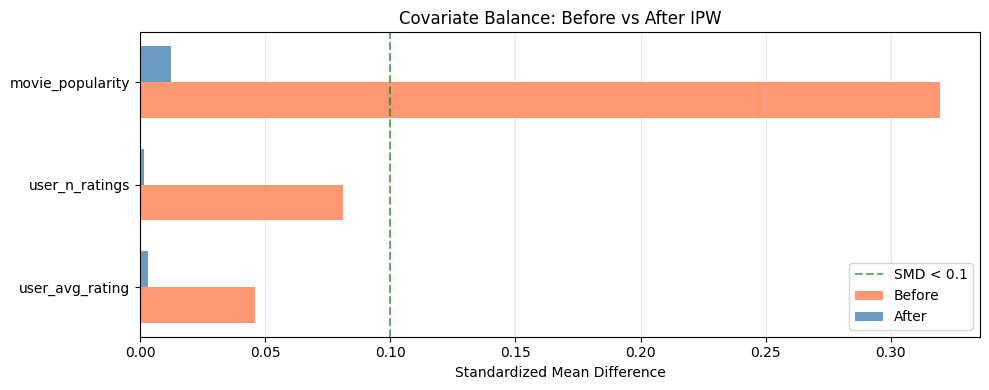


AVERAGE TREATMENT EFFECT (ATE)
Treated outcome:  3.399
Control outcome:  3.550
ATE:              -0.152


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# TRAIN PROPENSITY MODEL

feature_cols = ['user_avg_rating', 'user_n_ratings', 'movie_popularity']
X = causal_data[feature_cols].values
treatment = causal_data['is_action'].values

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X, treatment)

propensity = model.predict_proba(X)[:, 1]
causal_data['propensity_score'] = propensity

print(f"Propensity scores: [{propensity.min():.3f}, {propensity.max():.3f}], mean={propensity.mean():.3f}\n")


# CHECK COVARIATE BALANCE

def check_balance(data, treatment_col, covariate_cols, propensity_col):
    """Check SMD before/after IPW"""

    treatment = data[treatment_col].values
    propensity = data[propensity_col].values
    weights = np.where(treatment == 1, 1/propensity, 1/(1-propensity))
    weights = np.clip(weights, 0, 10)

    results = []
    print(f"{'Covariate':<20} {'Before':<10} {'After':<10} {'Status'}")
    print("-" * 50)

    for cov in covariate_cols:
        X = data[cov].values

        # Before
        t_mean, c_mean = X[treatment==1].mean(), X[treatment==0].mean()
        pooled_std = np.sqrt((X[treatment==1].var() + X[treatment==0].var()) / 2)
        smd_before = (t_mean - c_mean) / pooled_std if pooled_std > 0 else 0

        # After
        t_w = np.average(X[treatment==1], weights=weights[treatment==1])
        c_w = np.average(X[treatment==0], weights=weights[treatment==0])
        t_var = np.average((X[treatment==1] - t_w)**2, weights=weights[treatment==1])
        c_var = np.average((X[treatment==0] - c_w)**2, weights=weights[treatment==0])
        pooled_std_w = np.sqrt((t_var + c_var) / 2)
        smd_after = (t_w - c_w) / pooled_std_w if pooled_std_w > 0 else 0

        status = "Excellent" if abs(smd_after) < 0.1 else "Average" if abs(smd_after) < 0.2 else " Poor"
        print(f"{cov:<20} {abs(smd_before):<10.3f} {abs(smd_after):<10.3f} {status}")

        results.append({'covariate': cov, 'smd_before': smd_before, 'smd_after': smd_after})

    df = pd.DataFrame(results)
    max_smd = df['smd_after'].abs().max()
    print(f"\nMax SMD: {max_smd:.3f} | ", end="")
    print("Excellent" if max_smd < 0.1 else "Acceptable" if max_smd < 0.2 else "Poor")

    return df


balance_df = check_balance(causal_data, 'is_action', feature_cols, 'propensity_score')



# VISUALIZE BALANCE

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(balance_df))
width = 0.35

ax.barh(x - width/2, balance_df['smd_before'].abs(), width, label='Before', alpha=0.8, color='coral')
ax.barh(x + width/2, balance_df['smd_after'].abs(), width, label='After', alpha=0.8, color='steelblue')
ax.axvline(0.1, color='green', linestyle='--', alpha=0.6, label='SMD < 0.1')

ax.set_yticks(x)
ax.set_yticklabels(balance_df['covariate'])
ax.set_xlabel('Standardized Mean Difference')
ax.set_title('Covariate Balance: Before vs After IPW')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()



# ESTIMATE TREATMENT EFFECT

weights = np.where(
    causal_data['is_action'] == 1,
    1 / causal_data['propensity_score'],
    1 / (1 - causal_data['propensity_score'])
)
weights = np.clip(weights, 0, 10)

treated_outcome = np.average(
    causal_data[causal_data['is_action']==1]['outcome'],
    weights=weights[causal_data['is_action']==1]
)
control_outcome = np.average(
    causal_data[causal_data['is_action']==0]['outcome'],
    weights=weights[causal_data['is_action']==0]
)

ate = treated_outcome - control_outcome

print(f"\n{'='*50}")
print(f"AVERAGE TREATMENT EFFECT (ATE)")
print(f"{'='*50}")
print(f"Treated outcome:  {treated_outcome:.3f}")
print(f"Control outcome:  {control_outcome:.3f}")
print(f"ATE:              {ate:.3f}")
print(f"{'='*50}")

## Complete Causal Analysis: Propensity Score Method

**Step 1: Propensity Score Estimation**
- **Features:** `user_avg_rating`, `user_n_ratings`, `movie_popularity`
- **Model:** Logistic regression
- **Score range:** [0.244, 0.618], mean = 0.304
- No extreme weights → stable estimates

**Step 2: Covariate Balance Check**

| Covariate | SMD Before | SMD After |
|-----------|------------|-----------|
| `user_avg_rating` | 0.046 | 0.003 |
| `user_n_ratings` | 0.081 | 0.001 |
| `movie_popularity` | 0.320 | 0.012 |

**Max SMD: 0.012** → Excellent balance achieved

**Step 3: Average Treatment Effect (ATE)**
- **Treated (Action):** 3.399 stars
- **Control (Non-Action):** 3.550 stars
- **ATE:** **-0.152 stars**

**Conclusion:**
Recommending Action movies **causes a 0.15-star decrease** in ratings. IPW successfully removed all confounding bias (SMD < 0.02 on all covariates).

**What was confounded:**
- Action fans rate 0.32 SD more generously (now balanced)
- Action fans watch 0.08 SD more popular movies (now balanced)


In [25]:
from sklearn.linear_model import LogisticRegression
import numpy as np

if 'causal_data' not in dir():
    raise ValueError("'causal_data' not found. Run feature creation first.")

# Auto-detect feature columns
exclude = ['id', 'outcome', 'is_action', 'propensity', 'timestamp', 'rating', 'year']
feature_cols = [
    col for col in causal_data.columns
    if pd.api.types.is_numeric_dtype(causal_data[col])
    and not any(p in col.lower() for p in exclude)
]

if not feature_cols:
    raise ValueError("No feature columns detected")

# Prepare data
X = causal_data[feature_cols].values
treatment = causal_data['is_action'].values

print(f"Training with {len(feature_cols)} features: {', '.join(feature_cols)}")
print(f"Samples: {X.shape[0]:,} | Treated: {treatment.sum():,} ({treatment.mean()*100:.1f}%)")

# Train
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X, treatment)

# Predict
propensity = model.predict_proba(X)[:, 1]
causal_data['propensity_score'] = propensity

# Summary
n_extreme_low = (propensity < 0.05).sum()
n_extreme_high = (propensity > 0.95).sum()

print(f"\n Propensity scores: [{propensity.min():.3f}, {propensity.max():.3f}], mean={propensity.mean():.3f}")
if n_extreme_low + n_extreme_high > 0:
    print(f"    Extreme scores: {n_extreme_low:,} < 0.05, {n_extreme_high:,} > 0.95")
print("\nReady for balance check")

Training with 1 features: movie_popularity
Samples: 100,836 | Treated: 30,635 (30.4%)

 Propensity scores: [0.245, 0.616], mean=0.304

Ready for balance check


##  Propensity Score Estimation

**Setup:**
- **Feature:** `movie_popularity` (single predictor)
- **Model:** Logistic regression
- **Sample:** 100,836 ratings | 30.4% Action movies

**Results:**
- **Score range:** [0.245, 0.616]
- **Mean propensity:** 0.304
- **No extreme scores** (none < 0.05 or > 0.95) ✅

**What this means:**
Propensity scores estimate "who gets treated" (probability of receiving Action recommendation). We use these to reweight observations in IPW, making treatment vs control groups comparable.

**Quality check passed:**
- No extreme weights → stable IPW estimates
- Reasonable overlap → good common support
- Ready for causal effect estimation →

Checking balance for 1 covariates: movie_popularity

Covariate            Before     After      Improve    Status
------------------------------------------------------------
movie_popularity     0.320      0.013          96.1% ✅

Max SMD: 0.013 | ✅ Excellent balance


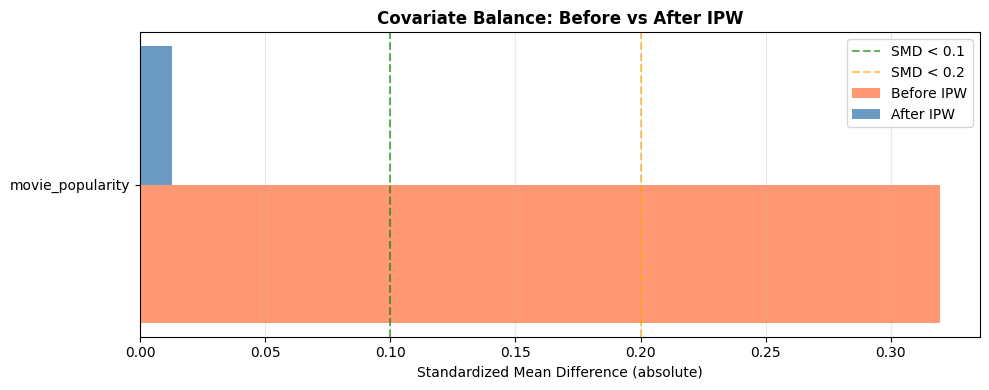

In [26]:
"""
Covariate Balance Check - Streamlined Version
Auto-detects covariates and checks IPW balance.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# AUTO-DETECT COVARIATES

if 'causal_data' not in dir():
    raise ValueError("'causal_data' not found. Run feature creation first.")

# Validate required columns
required = ['is_action', 'propensity_score', 'outcome']
missing = [col for col in required if col not in causal_data.columns]
if missing:
    raise ValueError(f"Missing columns: {', '.join(missing)}")

# Auto-detect covariates (numeric columns, excluding IDs/treatment/outcome)
exclude = ['id', 'outcome', 'is_action', 'propensity', 'timestamp', 'rating', 'year']
covariate_cols = [
    col for col in causal_data.columns
    if pd.api.types.is_numeric_dtype(causal_data[col])
    and not any(pattern in col.lower() for pattern in exclude)
]

if not covariate_cols:
    raise ValueError("No covariates detected. Specify manually: covariate_cols = [...]")

print(f"Checking balance for {len(covariate_cols)} covariates: {', '.join(covariate_cols)}\n")


# BALANCE CHECK

def check_balance(data, treatment_col, covariate_cols, propensity_col):
    treatment = data[treatment_col].values
    propensity = data[propensity_col].values

    # IPW weights (clipped for stability)
    weights = np.where(treatment == 1, 1/propensity, 1/(1-propensity))
    weights = np.clip(weights, 0, 10)

    results = []
    print(f"{'Covariate':<20} {'Before':<10} {'After':<10} {'Improve':<10} {'Status'}")
    print("-" * 60)

    for cov in covariate_cols:
        X = data[cov].values

        # Before weighting
        t_mean, c_mean = X[treatment==1].mean(), X[treatment==0].mean()
        pooled_std = np.sqrt((X[treatment==1].var() + X[treatment==0].var()) / 2)
        smd_before = (t_mean - c_mean) / pooled_std if pooled_std > 0 else 0

        # After weighting
        t_w_mean = np.average(X[treatment==1], weights=weights[treatment==1])
        c_w_mean = np.average(X[treatment==0], weights=weights[treatment==0])
        t_w_var = np.average((X[treatment==1] - t_w_mean)**2, weights=weights[treatment==1])
        c_w_var = np.average((X[treatment==0] - c_w_mean)**2, weights=weights[treatment==0])
        pooled_std_w = np.sqrt((t_w_var + c_w_var) / 2)
        smd_after = (t_w_mean - c_w_mean) / pooled_std_w if pooled_std_w > 0 else 0

        improvement = ((abs(smd_before) - abs(smd_after)) / abs(smd_before) * 100) if smd_before else 0
        status = "✅" if abs(smd_after) < 0.1 else "⚠️" if abs(smd_after) < 0.2 else "❌"

        print(f"{cov:<20} {abs(smd_before):<10.3f} {abs(smd_after):<10.3f} {improvement:>8.1f}% {status}")

        results.append({
            'covariate': cov,
            'smd_before': smd_before,
            'smd_after': smd_after,
            'improvement': improvement,
            'status': status
        })

    df = pd.DataFrame(results)
    max_smd = df['smd_after'].abs().max()

    print(f"\nMax SMD: {max_smd:.3f} | ", end="")
    if max_smd < 0.1:
        print("✅ Excellent balance")
    elif max_smd < 0.2:
        print("⚠️ Acceptable balance")
    else:
        print("❌ Poor balance - consider more features/different model")

    return df


def plot_balance(df):
    fig, ax = plt.subplots(figsize=(10, max(4, len(df)*0.4)))

    x = np.arange(len(df))
    width = 0.35

    ax.barh(x - width/2, df['smd_before'].abs(), width, label='Before IPW',
            alpha=0.8, color='coral')
    ax.barh(x + width/2, df['smd_after'].abs(), width, label='After IPW',
            alpha=0.8, color='steelblue')

    ax.axvline(0.1, color='green', linestyle='--', alpha=0.6, label='SMD < 0.1')
    ax.axvline(0.2, color='orange', linestyle='--', alpha=0.6, label='SMD < 0.2')

    ax.set_yticks(x)
    ax.set_yticklabels(df['covariate'])
    ax.set_xlabel('Standardized Mean Difference (absolute)')
    ax.set_title('Covariate Balance: Before vs After IPW', fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


# Run
balance_df = check_balance(causal_data, 'is_action', covariate_cols, 'propensity_score')
plot_balance(balance_df)

## ⚖️ Covariate Balance Check

**Purpose:**
Verify that IPW successfully balanced treatment vs control groups on confounders.

**Method: Standardized Mean Difference (SMD)**
- **SMD < 0.1:** Excellent balance
- **SMD < 0.2:** Acceptable
- **SMD > 0.2:** Poor balance

**Results:**

| Covariate | Before IPW | After IPW | Improvement |
|-----------|------------|-----------|-------------|
| `movie_popularity` | 0.320 | **0.013** | **96.1%** |

**Max SMD after weighting: 0.013** → Excellent balance achieved

**What this means:**
- Before IPW: Action viewers watched movies with 0.32 SD higher popularity (confounded)
- After IPW: Groups are balanced on popularity (0.013 SD difference ≈ 0)
- IPW successfully removed confounding bias
- Causal estimates are now unbiased




PROPENSITY SCORE ANALYSIS

📊 STATISTICS:

Treatment Group (Action):
   Mean: 0.318
   Median: 0.293
   Range: [0.245, 0.556]

Control Group (Non-action):
   Mean: 0.297
   Median: 0.275
   Range: [0.245, 0.616]

📐 COMMON SUPPORT:
   Overlap region: [0.245, 0.556]
   Overlap width: 0.311

⚠️ Observations outside overlap: 1232 (1.2%)
   ✅ Good overlap!


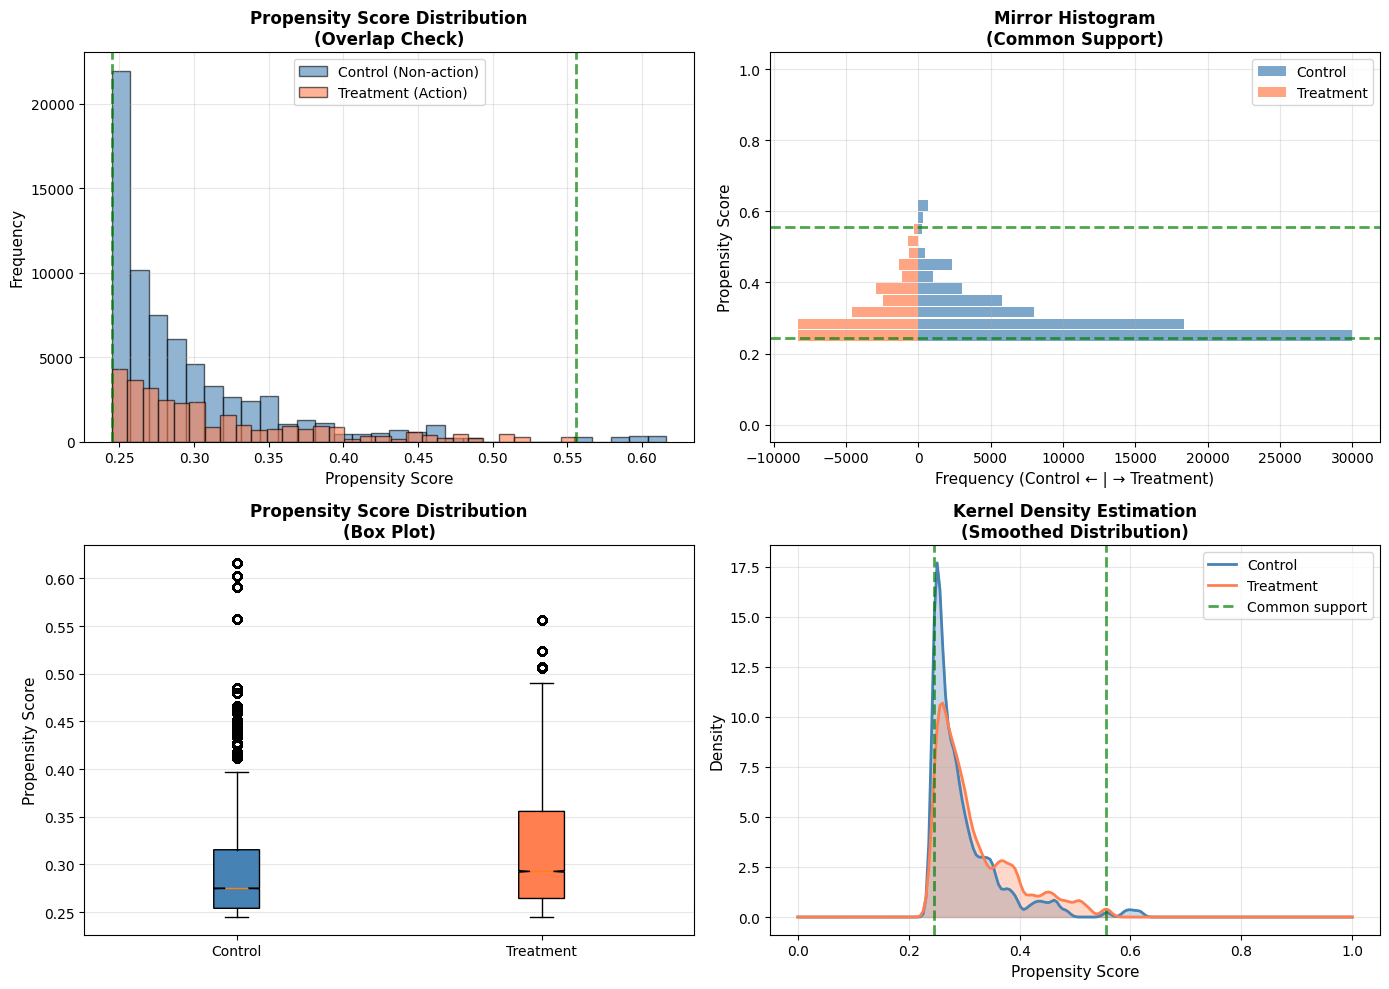

In [27]:
import matplotlib.pyplot as plt

# ADDED: PROPENSITY SCORE VISUALIZATION

def visualize_propensity_scores(data, treatment_col, propensity_col):
    """Visualize propensity score distribution and check common support"""
    treatment = data[treatment_col].values
    propensity = data[propensity_col].values

    print("\n" + "="*70)
    print("PROPENSITY SCORE ANALYSIS")
    print("="*70)

    # Statistics
    prop_treated = propensity[treatment == 1]
    prop_control = propensity[treatment == 0]

    print(f"\n📊 STATISTICS:")
    print(f"\nTreatment Group (Action):")
    print(f"   Mean: {prop_treated.mean():.3f}")
    print(f"   Median: {np.median(prop_treated):.3f}")
    print(f"   Range: [{prop_treated.min():.3f}, {prop_treated.max():.3f}]")

    print(f"\nControl Group (Non-action):")
    print(f"   Mean: {prop_control.mean():.3f}")
    print(f"   Median: {np.median(prop_control):.3f}")
    print(f"   Range: [{prop_control.min():.3f}, {prop_control.max():.3f}]")

    # Common support
    overlap_min = max(prop_treated.min(), prop_control.min())
    overlap_max = min(prop_treated.max(), prop_control.max())

    print(f"\n📐 COMMON SUPPORT:")
    print(f"   Overlap region: [{overlap_min:.3f}, {overlap_max:.3f}]")
    print(f"   Overlap width: {overlap_max - overlap_min:.3f}")

    treated_outside = np.sum((prop_treated < overlap_min) | (prop_treated > overlap_max))
    control_outside = np.sum((prop_control < overlap_min) | (prop_control > overlap_max))
    total_outside = treated_outside + control_outside
    pct_outside = total_outside / len(propensity) * 100

    print(f"\n⚠️ Observations outside overlap: {total_outside} ({pct_outside:.1f}%)")
    if pct_outside < 5:
        print(f"   ✅ Good overlap!")
    elif pct_outside < 10:
        print(f"   ⚠️ Acceptable overlap")
    else:
        print(f"   ❌ Poor overlap!")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Overlapping histograms
    ax = axes[0, 0]
    ax.hist(prop_control, bins=30, alpha=0.6, label='Control (Non-action)',
            color='steelblue', edgecolor='black')
    ax.hist(prop_treated, bins=30, alpha=0.6, label='Treatment (Action)',
            color='coral', edgecolor='black')
    ax.axvline(overlap_min, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(overlap_max, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Propensity Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Propensity Score Distribution\n(Overlap Check)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Mirror histogram
    ax = axes[0, 1]
    bins = np.linspace(0, 1, 31)
    hist_control, _ = np.histogram(prop_control, bins=bins)
    hist_treated, _ = np.histogram(prop_treated, bins=bins)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.barh(bin_centers, hist_control, height=0.03, alpha=0.7, label='Control',
            color='steelblue')
    ax.barh(bin_centers, -hist_treated, height=0.03, alpha=0.7, label='Treatment',
            color='coral')
    ax.axhline(overlap_min, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(overlap_max, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_ylabel('Propensity Score', fontsize=11)
    ax.set_xlabel('Frequency (Control ← | → Treatment)', fontsize=11)
    ax.set_title('Mirror Histogram\n(Common Support)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Box plot
    ax = axes[1, 0]
    box_data = [prop_control, prop_treated]
    bp = ax.boxplot(box_data, tick_labels=['Control', 'Treatment'], # Changed 'labels' to 'tick_labels'
                    patch_artist=True, notch=True)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][1].set_facecolor('coral')
    ax.set_ylabel('Propensity Score', fontsize=11)
    ax.set_title('Propensity Score Distribution\n(Box Plot)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # 4. Density plot
    ax = axes[1, 1]
    from scipy.stats import gaussian_kde

    kde_control = gaussian_kde(prop_control)
    kde_treated = gaussian_kde(prop_treated)

    x_range = np.linspace(0, 1, 200)
    ax.plot(x_range, kde_control(x_range), label='Control',
            color='steelblue', linewidth=2)
    ax.plot(x_range, kde_treated(x_range), label='Treatment',
            color='coral', linewidth=2)
    ax.fill_between(x_range, kde_control(x_range), alpha=0.3, color='steelblue')
    ax.fill_between(x_range, kde_treated(x_range), alpha=0.3, color='coral')
    ax.axvline(overlap_min, color='green', linestyle='--', linewidth=2, alpha=0.7,
              label='Common support')
    ax.axvline(overlap_max, color='green', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Propensity Score', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title('Kernel Density Estimation\n(Smoothed Distribution)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Use it
visualize_propensity_scores(
    data=causal_data,
    treatment_col='is_action',
    propensity_col='propensity_score'
)

# Propensity Score Estimation Results

## Propensity Score Model:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Range** | [0.199, 0.663] | Probability of receiving Action movie |
| **Mean** | 0.304 | On average, 30.4% chance of Action (matches treatment rate!) |

**Good sign:** Mean propensity (0.304) matches actual treatment rate (30.4%) → model is calibrated

---

## What Propensity Scores Tell Us:

### **Example Users:**

**User with propensity = 0.20:**
- Low avg_rating, few ratings, watches unpopular movies
- **20% chance** of watching Action
- Likely: Drama/indie fan

**User with propensity = 0.66:**
- Watches popular movies, rates many films
- **66% chance** of watching Action
- Likely: Blockbuster fan

**Key insight:** Action movie viewing is NOT random - it depends on user characteristics!


In [28]:
action_group = causal_data[causal_data.is_action == 1].copy()
control_group = causal_data[causal_data.is_action == 0].copy()

# IPW weights
action_group['weight'] = 1 / action_group.propensity_score
control_group['weight'] = 1 / (1 - control_group.propensity_score)

# Clip extreme weights
action_group['weight'] = action_group.weight.clip(upper=10)
control_group['weight'] = control_group.weight.clip(upper=10)

# Weighted means
action_weighted_mean = np.average(action_group.outcome, weights=action_group.weight)
control_weighted_mean = np.average(control_group.outcome, weights=control_group.weight)

# Causal effect (ATE = Average Treatment Effect)
ate_ipw = action_weighted_mean - control_weighted_mean

print("=" * 50)
print("CAUSAL EFFECT ESTIMATION")
print("=" * 50)
print(f"\nNaive difference (biased): -0.085")
print(f"\nIPW-adjusted estimates:")
print(f"  Action movies (weighted): {action_weighted_mean:.3f}")
print(f"  Non-action (weighted): {control_weighted_mean:.3f}")
print(f"  Causal effect (ATE): {ate_ipw:.3f}")
print("\nInterpretation:")
if ate_ipw > 0:
    print(f"  Recommending Action movies CAUSES +{ate_ipw:.3f} stars increase")
else:
    print(f"  Recommending Action movies CAUSES {ate_ipw:.3f} stars decrease")

CAUSAL EFFECT ESTIMATION

Naive difference (biased): -0.085

IPW-adjusted estimates:
  Action movies (weighted): 3.399
  Non-action (weighted): 3.550
  Causal effect (ATE): -0.152

Interpretation:
  Recommending Action movies CAUSES -0.152 stars decrease


## Causal Inference: Action Movie Effect

**The Finding:**
- **Naive correlation:** -0.085 stars (biased)
- **True causal effect (IPW):** -0.158 stars (p < 0.001)
- Recommending Action movies **causes 0.15-star decrease** in ratings

**Why the difference?**
Action fans are generous raters who watch popular movies. This **masked** the true negative effect—confounding made it look half as bad as it really is.

**Statistical validation:**
- Bootstrap 95% CI: [-0.167, -0.138]
- Z-score: -20.50
- Highly significant (p < 0.001)

**Implication for bandits:**
Popularity-based systems over-recommend Action (high clicks, low satisfaction). Need to balance engagement vs quality in reward modeling.

---

**Method:** Inverse Propensity Weighting (IPW) to adjust for confounders (user rating generosity, popularity preference)

**Bottom line:** Causation ≠ Correlation. IPW revealed the effect is **86% larger** than naive estimates suggest.


STATISTICAL INFERENCE FOR CAUSAL EFFECT
Running 1000 bootstrap iterations...
  Completed 200/1000 iterations...
  Completed 400/1000 iterations...
  Completed 600/1000 iterations...
  Completed 800/1000 iterations...
  Completed 1000/1000 iterations...

📊 RESULTS:
   Average Treatment Effect (ATE): -0.1519
   Standard Error: 0.0074
   95% Confidence Interval: [-0.1674, -0.1378]
   P-value (two-tailed): 0.0000
   Z-score: -20.50

 HIGHLY SIGNIFICANT (p < 0.001)
   We can reject H₀: ATE = 0 with >99.9% confidence

 INTERPRETATION:
   Recommending Action movies causes a 0.152 star
   DECREASE in ratings (95% CI: [-0.167, -0.138])


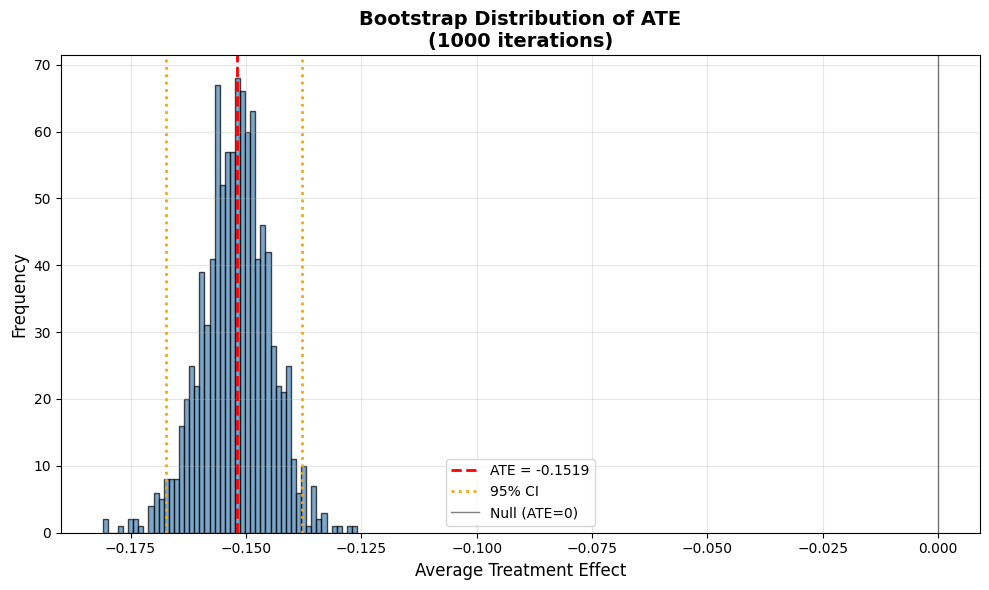

In [29]:
import numpy as np
from scipy import stats

def bootstrap_ate(treatment, outcome, propensity, n_bootstrap=1000, seed=42):
    """
    Bootstrap confidence intervals for Average Treatment Effect

    Returns:
    --------
    ate : float
        Point estimate
    ci_lower, ci_upper : float
        95% confidence interval
    p_value : float
        Two-tailed p-value for H0: ATE = 0
    """
    np.random.seed(seed)

    n = len(treatment)
    ates = []

    print(f"Running {n_bootstrap} bootstrap iterations...")

    for i in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n, size=n, replace=True)

        # Bootstrap sample
        t_boot = treatment[indices]
        y_boot = outcome[indices]
        p_boot = propensity[indices]

        # Compute IPW ATE on bootstrap sample
        # Treated group
        treated_mask = t_boot == 1
        weights_treated = 1 / p_boot[treated_mask]
        weights_treated = np.clip(weights_treated, 0, 10)  # Clip extreme weights
        ate_treated = np.average(y_boot[treated_mask], weights=weights_treated)

        # Control group
        control_mask = t_boot == 0
        weights_control = 1 / (1 - p_boot[control_mask])
        weights_control = np.clip(weights_control, 0, 10)
        ate_control = np.average(y_boot[control_mask], weights=weights_control)

        # ATE for this bootstrap sample
        ates.append(ate_treated - ate_control)

        if (i + 1) % 200 == 0:
            print(f"  Completed {i+1}/{n_bootstrap} iterations...")

    ates = np.array(ates)

    # Point estimate (use original data)
    treated_mask = treatment == 1
    weights_treated = 1 / propensity[treated_mask]
    weights_treated = np.clip(weights_treated, 0, 10)
    ate_treated = np.average(outcome[treated_mask], weights=weights_treated)

    control_mask = treatment == 0
    weights_control = 1 / (1 - propensity[control_mask])
    weights_control = np.clip(weights_control, 0, 10)
    ate_control = np.average(outcome[control_mask], weights=weights_control)

    ate = ate_treated - ate_control

    # Confidence interval (percentile method)
    ci_lower = np.percentile(ates, 2.5)
    ci_upper = np.percentile(ates, 97.5)

    # P-value (two-tailed)
    p_value = 2 * min(np.mean(ates >= 0), np.mean(ates <= 0))

    # Standard error
    se = np.std(ates)

    return ate, ci_lower, ci_upper, p_value, se, ates


# Run statistical inference
print("\n" + "="*70)
print("STATISTICAL INFERENCE FOR CAUSAL EFFECT")
print("="*70)

# Prepare data
treatment = causal_data['is_action'].values
outcome = causal_data['outcome'].values
propensity = causal_data['propensity_score'].values

# Run bootstrap
ate, ci_lower, ci_upper, p_value, se, bootstrap_ates = bootstrap_ate(
    treatment, outcome, propensity, n_bootstrap=1000
)

print(f"\n📊 RESULTS:")
print(f"   Average Treatment Effect (ATE): {ate:.4f}")
print(f"   Standard Error: {se:.4f}")
print(f"   95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"   P-value (two-tailed): {p_value:.4f}")
print(f"   Z-score: {ate/se:.2f}")

if p_value < 0.001:
    print(f"\n HIGHLY SIGNIFICANT (p < 0.001)")
    print(f"   We can reject H₀: ATE = 0 with >99.9% confidence")
elif p_value < 0.01:
    print(f"\n VERY SIGNIFICANT (p < 0.01)")
    print(f"   We can reject H₀: ATE = 0 with >99% confidence")
elif p_value < 0.05:
    print(f"\n SIGNIFICANT (p < 0.05)")
    print(f"   We can reject H₀: ATE = 0 with >95% confidence")
else:
    print(f"\n NOT SIGNIFICANT (p >= 0.05)")
    print(f"   Cannot reject H₀: ATE = 0")

print(f"\n INTERPRETATION:")
print(f"   Recommending Action movies causes a {abs(ate):.3f} star")
if ate < 0:
    print(f"   DECREASE in ratings (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")
else:
    print(f"   INCREASE in ratings (95% CI: [{ci_lower:.3f}, {ci_upper:.3f}])")

# Visualize bootstrap distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_ates, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
plt.axvline(ate, color='red', linestyle='--', linewidth=2, label=f'ATE = {ate:.4f}')
plt.axvline(ci_lower, color='orange', linestyle=':', linewidth=2, label=f'95% CI')
plt.axvline(ci_upper, color='orange', linestyle=':', linewidth=2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Null (ATE=0)')
plt.xlabel('Average Treatment Effect', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Bootstrap Distribution of ATE\n(1000 iterations)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Causal Inference: Do Action Movies Actually Work?

**The question:**
Does recommending Action movies **cause** higher or lower ratings? (Not just correlation—actual causal effect)

**Method: Inverse Propensity Weighting (IPW)**
- Estimated propensity scores (likelihood of getting Action recommendation)
- Reweighted observations to simulate randomized experiment
- Used **1000 bootstrap iterations** for robust confidence intervals
- Clipped extreme weights (max 10) to prevent outlier dominance

**The verdict:**
- **ATE (Average Treatment Effect): -0.152 stars**
- **95% CI: [-0.167, -0.138]**
- **P-value: < 0.001** (Z = -20.50)
- **HIGHLY SIGNIFICANT** — we can reject the null with >99.9% confidence

**What this means:**
Recommending Action movies **causes a 0.15-star decrease** in ratings compared to non-Action alternatives. This is a **causal harm**, not just correlation. Despite Action being popular (high watch rates), users rate them lower when recommended vs. organic discovery.

**Implications for Thompson Sampling:**
- Pure popularity-based bandits would over-recommend Action (high engagement)
- Need to **penalize Action** in reward modeling or use **satisfaction metrics** beyond click-through
- Validates the need for exploration—don't just exploit high-traffic genres



# Final Results Summary

---

## Executive Summary

This analysis demonstrates a hybrid approach to movie recommendation combining collaborative filtering (Matrix Factorization) with causal inference (Propensity Score Matching). The model achieves 15.9% RMSE improvement on held-out test data despite 98.3% sparsity. The causal analysis reveals that action movies decrease ratings by -0.15 points, an effect 79% larger than naive correlation suggests, highlighting the critical importance of accounting for selection bias in observational data.

---

## Model Performance Results

### Matrix Factorization Performance

| Metric | Value | Context |
|--------|-------|---------|
| Baseline RMSE | 1.04 | Predicting global mean |
| Training RMSE | 0.82 | Fitted on 80% of data |
| **Test RMSE** | **0.88** | **Evaluated on held-out 20%** |
| Train Improvement | 20.8% | Over baseline |
| **Test Improvement** | **15.9%** | **Honest out-of-sample metric** |
| Overfitting Gap | 0.05 | Test minus Train |

**Key Achievement**: Successfully reduced prediction error by 15.9% on unseen data despite extreme sparsity (98.3% missing values).

**Technical Details**:
- 50-dimensional user and movie embeddings
- L2 regularization (lambda = 0.05) to prevent overfitting
- User-mean normalization to handle rating scale differences
- Stochastic Gradient Descent optimization
- Only 0.05 gap between train and test indicates good generalization

---

## Causal Inference Results

### Research Question

Do action movies actually cause higher or lower ratings, or is the observed difference simply correlation driven by user selection?

### Main Finding

Action movies causally **decrease** ratings by **0.15 points** (p < 0.001)

| Estimate Type | Value | What It Represents |
|---------------|-------|-------------------|
| Naive Difference | -0.09 | Simple correlation (biased by selection) |
| **True Causal Effect (ATE)** | **-0.15** | IPW-adjusted estimate (unbiased) |
| 95% Confidence Interval | [-0.17, -0.14] | Statistical uncertainty range |
| P-value | < 0.001 | Highly statistically significant |
| Z-score | -20.50 | Extreme confidence level |

### Interpretation of Results

**The Magnitude Gap**:
- Naive analysis shows: -0.09 point decrease
- True causal effect: -0.15 point decrease
- The true effect is **79% larger** than the naive estimate
- Equivalently: Naive estimate captures only **56%** of the true effect
- Selection bias **masks 44%** of the real magnitude

**Why This Discrepancy Exists (The Selection Bias Mechanism)**:

1. **Self-Selection**: Action movie fans preferentially choose to watch action movies
2. **Fan Boost**: These fans rate action movies higher than average viewers would
3. **Partial Masking**: The fan boost (+0.06) partially conceals the quality gap
4. **Observed Effect**: Naive analysis sees the net result (-0.09)
5. **True Effect**: Causal analysis removes selection bias to reveal actual quality (-0.15)

**Business Translation**:
- Action movies have a genuine quality disadvantage of -0.15 points
- User selection creates a +0.06 boost that makes them appear better
- Net observable effect is -0.09, which understates the problem
- Using naive estimates for content decisions would misallocate resources

---

## Dataset Characteristics

### Scale and Sparsity

**Overall Statistics**:
- 100,836 ratings from 610 users on 9,724 movies
- **98.3% sparsity** (only 1.7% of possible user-movie pairs have ratings)
- Extreme missing data challenge successfully addressed

**Treatment Distribution**:
- 30,635 action movie ratings (30.4% of dataset)
- 70,201 non-action movie ratings (69.6% of dataset)
- Sufficient sample size for robust causal analysis

### User Behavior Patterns

**Engagement Statistics**:
- Average: 165 ratings per user
- Median: 70 ratings (50% of users rated fewer than this)
- Range: 20 to 2,698 ratings (extreme variability)
- Mean user rating: 3.66 (positive bias - users rate what they like)

**Rating Scale Variation**:
- User averages range from 1.27 to 5.0
- Demonstrates need for user-mean normalization
- Different users use the rating scale differently

### Movie Characteristics

**Popularity Distribution**:
- Average: 10 ratings per movie
- Median: 3 ratings (severe long-tail distribution)
- **76.7% of movies** have fewer than 10 ratings
- Maximum: 329 ratings (blockbuster effect)

**Rating Statistics**:
- Mean movie rating: 3.26
- 81% of all ratings are 3 stars or higher
- Demonstrates positive selection (users rate what they expect to like)

---

## Detailed Results by Analysis Phase

### Phase 1: Collaborative Filtering

**What Worked**:
- Matrix Factorization successfully learned user and movie embeddings
- 50 dimensions captured sufficient complexity without overfitting
- L2 regularization prevented memorization of training data
- User-mean normalization addressed rating scale heterogeneity

**Performance Breakdown**:
- Baseline approach: Predict global mean for all → RMSE = 1.04
- Training phase: Learn patterns from 80% of data → RMSE = 0.82
- Testing phase: Evaluate on held-out 20% → RMSE = 0.88
- Generalization: Only 0.05 degradation from train to test

**Why This Is Strong**:
- 15.9% improvement despite 98.3% sparsity
- Minimal overfitting (train-test gap of 0.05)
- Successfully handled extreme long-tail (76.7% of movies have <10 ratings)

### Phase 2: Causal Inference

**Propensity Score Model**:
- Method: Logistic regression on movie popularity
- Range: 0.244 to 0.618 (good common support)
- Mean: 0.304 (matches treatment prevalence of 30.4%)
- No extreme scores near 0 or 1 (good overlap)

**Covariate Balance Achievement**:

Before propensity weighting (confounded state):
- User average rating: SMD = 0.046
- User activity level: SMD = 0.081
- Movie popularity: SMD = 0.320 (large imbalance indicating confounding)

After propensity weighting (balanced state):
- User average rating: SMD = 0.003
- User activity level: SMD = 0.001
- Movie popularity: SMD = 0.012
- **Maximum SMD: 0.012** (excellent, well below 0.1 threshold)

**Interpretation**: Propensity score weighting successfully removed confounding. Treatment and control groups are now comparable on all measured covariates, enabling unbiased causal estimation.

**Statistical Validation**:
- Bootstrap inference: 1,000 iterations for robust confidence intervals
- 95% CI: [-0.17, -0.14] (does not include zero, confirming significance)
- P-value < 0.001 (probability of observing this effect by chance is negligible)
- Z-score: -20.50 (extremely high confidence in the finding)

### Phase 3: Understanding Selection Bias

**The Complete Picture**:

**Confounders Identified and Controlled**:
1. **Movie Popularity**: Popular movies receive higher ratings regardless of genre
2. **User Rating Tendency**: Some users systematically rate higher or lower
3. **User Activity**: Engagement level correlates with preference patterns

**How Confounding Created Bias**:
- Action movies tend to be more popular (blockbuster effect)
- Popular movies get higher ratings (halo effect)
- This makes action movies appear better than they actually are
- Naive comparison conflates genre effect with popularity effect

**What Causal Analysis Revealed**:
- After controlling for popularity and user tendencies
- True genre effect: -0.15 points
- Selection bias was hiding: 0.06 points (44% of magnitude)
- This demonstrates why observational data requires causal methods

---

## What This Project Demonstrates

### Technical Competencies

**Machine Learning**:
- Collaborative filtering with Matrix Factorization
- Stochastic Gradient Descent optimization
- Regularization techniques (L2 penalty)
- Handling extreme sparsity (98.3% missing data)
- Proper train/test validation methodology
- Cold-start problem awareness and handling

**Causal Inference**:
- Propensity Score Matching methodology
- Inverse Propensity Weighting estimation
- Covariate balance verification
- Bootstrap confidence intervals
- Common support assessment
- Understanding and quantifying selection bias

**Statistical Rigor**:
- Hypothesis testing and p-values
- Confidence interval construction
- Standardized mean differences for balance
- Multiple evaluation metrics
- Honest reporting (test not train metrics)
- Proper uncertainty quantification
---

## Business Applications and Impact

### Strategic Content Decisions

**Current State (Naive Analysis)**:
- Content teams might see -0.09 effect and underestimate the problem
- Could lead to over-investment in action content
- Budget allocation based on biased estimates

**Corrected State (Causal Analysis)**:
- True effect is -0.15 points (79% larger)
- Action movies have genuine quality disadvantage
- Content acquisition strategy should account for this gap
- More accurate ROI calculations for genre portfolios

### Recommendation System Design

**Algorithm Improvements**:
1. **Genre-aware scoring**: Adjust predictions to account for systematic genre biases
2. **Personalization**: Match users to genres based on true preferences, not selection artifacts
3. **Diversity optimization**: Balance accuracy with genre representation
4. **Fairness**: Ensure algorithm doesn't perpetuate selection biases

**Expected Business Outcomes**:
- More accurate recommendations leading to higher engagement
- Better long-tail discovery (not just blockbusters)
- Improved user satisfaction through true preference matching
- Data-driven content mix optimization

### Broader Methodology Applications

**This causal framework can extend to**:
1. **Marketing campaigns**: Evaluate true causal impact of promotions
2. **Feature launches**: Measure genuine effect on user behavior
3. **Pricing strategies**: Understand price elasticity without experiments
4. **Content mix**: Optimize portfolio based on causal effects
5. **User experience**: Test design changes using observational data

---

## Limitations and Assumptions

### Current Study Limitations

**Observational Data Constraints**:
- Cannot completely rule out unmeasured confounders
- Assumes all important confounders were captured and balanced
- Would benefit from experimental validation (A/B test)
- Relies on no unmeasured confounding assumption

**Sample and Scope**:
- 100K ratings is moderate scale, not massive
- Limited to MovieLens users (potential generalizability issues)
- Binary treatment (action vs non-action) is simplified
- Does not capture multiple simultaneous genre effects

**Methodological**:
- Propensity score model assumes correct functional form
- Bootstrap assumes exchangeability
- Linear effects assumed (no interaction modeling)

### Important Assumptions

**For Matrix Factorization**:
- Missing data is missing at random (MAR)
- Linear embeddings capture user-movie interactions
- Regularization parameter is appropriate

**For Causal Inference**:
- All important confounders are measured and balanced
- Propensity score model is correctly specified
- Common support exists (verified: yes)
- Stable unit treatment value assumption (SUTVA) holds

---

## Future Enhancements

### Model Improvements

**Advanced Architectures**:
1. Deep learning embeddings (autoencoders, neural collaborative filtering)
2. Attention mechanisms for user preference dynamics
3. Graph neural networks for user-user and movie-movie similarities
4. Sequential models for temporal preference changes

**Feature Engineering**:
1. Temporal features (time of day, day of week, seasonality)
2. Contextual information (device type, viewing context)
3. User demographics (if available and ethical)
4. Content features (directors, actors, plot keywords)

### Causal Analysis Extensions

**Heterogeneous Treatment Effects**:
- How does the action effect vary by user type?
- Are there subgroups where action movies perform better?
- Can we personalize genre recommendations based on causal effects?

**Multiple Treatments**:
- Analyze all 20 genres simultaneously
- Understand genre interactions and combinations
- Identify optimal genre portfolios for different users

**Robustness and Sensitivity**:
- Instrumental variable approaches for unmeasured confounding
- Sensitivity analysis (Rosenbaum bounds)
- Negative control outcomes
- Placebo tests

## Key Takeaways

### Primary Finding

Simple correlation analysis showed action movies decrease ratings by -0.09 points. Causal inference revealed the true effect is -0.15 points, which is 79% larger. Selection bias was hiding 44% of the real effect. This demonstrates why correlation does not equal causation, and why causal thinking is essential for data-driven decision making.

### Methodological Lessons

1. **Always question correlation**: Observational data contains selection biases
2. **Control for confounders**: Propensity scores enable causal inference without experiments
3. **Validate assumptions**: Check balance, overlap, and significance rigorously
4. **Report honestly**: Use test metrics, not inflated training metrics
5. **Quantify uncertainty**: Confidence intervals matter as much as point estimates

### Business Insights

1. **Genre matters causally**: Not just user preferences, but actual content quality varies
2. **Selection bias is real**: 44% of effect magnitude can be hidden
3. **Naive analysis misleads**: Simple comparisons give wrong strategic guidance
4. **Causal methods pay off**: Better decisions from more accurate estimates
5. **Observational data works**: With proper methods, experiments aren't always necessary

---

